# **Multi Agents RAG**

[Link to the paper](https://arxiv.org/html/2312.04854v1)

**Architecture**:

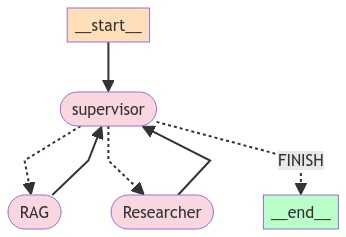

Before I begin, I will load environment keys:

In [35]:
import os
from dotenv import load_dotenv

load_dotenv()


from langchain_openai import ChatOpenAI

# Now you can access your environment variables using os.environ
os.environ['OPENAI_API_KEY'] = os.environ.get("OPENAI_API_KEY")
os.environ['TAVILY_API_KEY'] = os.environ.get("TAVILY_API_KEY")


llm = ChatOpenAI(model="gpt-3.5-turbo")

### Create Agent function

In [36]:
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.prompts import MessagesPlaceholder
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI


def create_agent(llm: ChatOpenAI, tools: list, system_prompt: str):
    # Each worker node will be given a name and some tools.
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor



### Creation of Tools 

- Tavily Search tool

In [51]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool


tavily_tool = TavilySearchResults(max_results=5)

### RAG Setup with vector DB

Data Ingestion:

In [ ]:
# Download PDF file
import requests

# Get PDF document
pdf_path = "human-nutrition-text.pdf"

# Download PDF if it doesn't already exist
if not os.path.exists(pdf_path):
  print("File doesn't exist, downloading...")

  # The URL of the PDF you want to download
  url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"

  # The local filename to save the downloaded file
  filename = pdf_path

  # Send a GET request to the URL
  response = requests.get(url)

  # Check if the request was successful
  if response.status_code == 200:
      # Open a file in binary write mode and save the content to it
      with open(filename, "wb") as file:
          file.write(response.content)
      print(f"The file has been downloaded and saved as {filename}")
  else:
      print(f"Failed to download the file. Status code: {response.status_code}")
else:
  print(f"File {pdf_path} exists.")

Indexing:

In [38]:
import os
from langchain_community.embeddings.sentence_transformer import SentenceTransformerEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import PyMuPDFLoader

# Check if there is a FAISS index locally
index_path = "faiss_index"
if os.path.exists(index_path):
    # Load the existing FAISS index
    hf = SentenceTransformerEmbeddings(model_name="avsolatorio/GIST-all-MiniLM-L6-v2")
    vectorstore = FAISS.load_local(index_path, hf, allow_dangerous_deserialization=True)
    retriever = vectorstore.as_retriever(search_kwargs={"k": 7})
else:
    # Load the document and create embeddings
    loader = PyMuPDFLoader(input(""))
    text_data = loader.load()
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=500,
        chunk_overlap=20,
        length_function=len,
        is_separator_regex=False
    )
    chunks = text_splitter.split_documents(text_data)
    hf = SentenceTransformerEmbeddings(model_name="avsolatorio/GIST-all-MiniLM-L6-v2")
    vectorstore = FAISS.from_documents(chunks, hf)
    retriever = vectorstore.as_retriever(search_kwargs={"k": 7})
    # Save the FAISS index locally
    vectorstore.save_local(index_path)

c:\Users\Odiaka\miniconda3\envs\rag\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [39]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

### RAG Tool : Python function -> tool

In [40]:
@tool
def RAG(state):

    """Use this to execute RAG. If the question is related to human nutrition, using this tool retrieve the results."""

    print('-> Calling RAG ->')
    question = state
    print('Question:',question)

    template = """Answer the question based only on the following context:
    {context}

    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)

    retrieval_chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
        )
    result = retrieval_chain.invoke(question)
    return result

### Agent node 
 - takes state , agent and name as input 
 - return mesage as HumanMessage with name

In [41]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

### Supervisor Chain creation 

The team supervisor is an LLM node. It just picks the next agent to process and decides when the work is completed

- Has access and information about it's memebers. 
- members = ["RAG" , "Researcher"]
- options = ["FINISH"] + members
- "Given the conversation above, who should act next?"
   " Or should we FINISH? Select one of: {options}, but select FINISH when the question has been answered."

- Router -> function_def

In [42]:
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

members = ["RAG" , "Researcher"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Use RAG tool when questions "
     "are related to human nutrition category. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

options = ["FINISH"] + members
# Using openai function calling can make output parsing easier for us
function_def = {
    "name": "route",
    "description": "Select the next role.",
    "parameters": {
        "title": "routeSchema",
        "type": "object",
        "properties": {
            "next": {
                "title": "Next",
                "anyOf": [
                    {"enum": options},
                ],
            }
        },
        "required": ["next"],
    },
}
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}, but select FINISH when the question has been answered.",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

supervisor_chain = (
    prompt
    | llm.bind_functions(functions=[function_def], function_call="route")
    | JsonOutputFunctionsParser()
)

### Creation of workflow with below nodes 

Agent ->> Node (functools.partial)

 - Research Node
 - RAG Node

In [52]:
import operator
from typing import Annotated, Sequence, TypedDict
import functools

from langgraph.graph import StateGraph, END


# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str


research_agent = create_agent(llm, [tavily_tool], "Use this tool to search the internet.")
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")


RAG_agent = create_agent(
    llm,
    [RAG],
    "Use this tool when questions are related to human nutrition category.",
)
rag_node = functools.partial(agent_node, agent=RAG_agent, name="RAG")

workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("RAG", rag_node)
workflow.add_node("supervisor", supervisor_chain)

In [53]:
members

['RAG', 'Researcher']

### Creation of edges

In [54]:
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "supervisor")
# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)
# Finally, add entrypoint
workflow.set_entry_point("supervisor")

graph = workflow.compile()

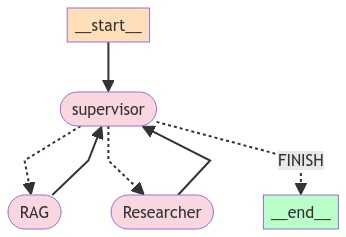

In [46]:
from IPython.display import Image, display

graph.get_graph().draw_mermaid_png(output_file_path="graph.png")

# Display the image
display(Image(filename="graph.png"))

In [47]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="What are macronutrients?")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'RAG'}}
----
-> Calling RAG ->
Question: Macronutrients are nutrients that provide energy and are required in large amounts by the body. The three main macronutrients are carbohydrates, proteins, and fats. Carbohydrates are the body's main source of energy, proteins are essential for growth and repair of tissues, and fats provide energy and help in the absorption of fat-soluble vitamins. Adequate consumption of macronutrients is essential for maintaining good health and proper body function.
{'RAG': {'messages': [HumanMessage(content="Macronutrients are nutrients that provide energy and are required in large amounts by the body. The three main macronutrients are carbohydrates, proteins, and fats. Carbohydrates are the body's main source of energy, proteins are essential for growth and repair of tissues, and fats provide energy and help in the absorption of fat-soluble vitamins. Adequate consumption of macronutrients is essential for maintaining good health and p

In [48]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="and what are those needed in small quantities called?")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'RAG'}}
----
-> Calling RAG ->
Question: Human nutrition
{'RAG': {'messages': [HumanMessage(content='Nutrients needed in small quantities are called micronutrients. These include vitamins and minerals that are essential for various bodily functions despite being required in smaller amounts compared to macronutrients like carbohydrates, proteins, and fats.', name='RAG')]}}
----
{'supervisor': {'next': 'FINISH'}}
----


In [55]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="When did Messi last score a goal")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'Researcher'}}
----
{'Researcher': {'messages': [HumanMessage(content='Lionel Messi last scored a goal on March 25, 2024, while playing for Inter Miami CF in the MLS.', name='Researcher')]}}
----
{'supervisor': {'next': 'FINISH'}}
----
